In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform

## First let's inspect our labeled landcover dataset

In [2]:
# Open our raster dataset
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

# How many bands does this image have?
num_bands = label_dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = label_dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = label_dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = label_dataset.crs
print('Image projection:')
print(proj)

Number of bands in image: 1

Image size is: 17107 rows x 21332 columns

Raster driver: GTiff

Image projection:
EPSG:32618


### What is the pixel size?

In [3]:
gt = label_dataset.transform
print(gt)

| 30.00, 0.00,-130215.00|
| 0.00,-30.00, 4187595.00|
| 0.00, 0.00, 1.00|


In [4]:
pixelSizeX = gt[0]
pixelSizeY =-gt[4]

print(pixelSizeX)
print(pixelSizeY)

30.0
30.0


#### What is the image shape?

In [5]:
label_image.shape

(1, 17107, 21332)

#### how many classes are there?

In [6]:
np.unique(label_image)

array([  0,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22, 255], dtype=uint8)

#### For now I'm just combining all pixels currently classified as 255 into class 1

But it might be worth combining other classes here too and saving out the raster as something new


In [7]:
label_image[label_image == 255] = 1

Let's take a look at it

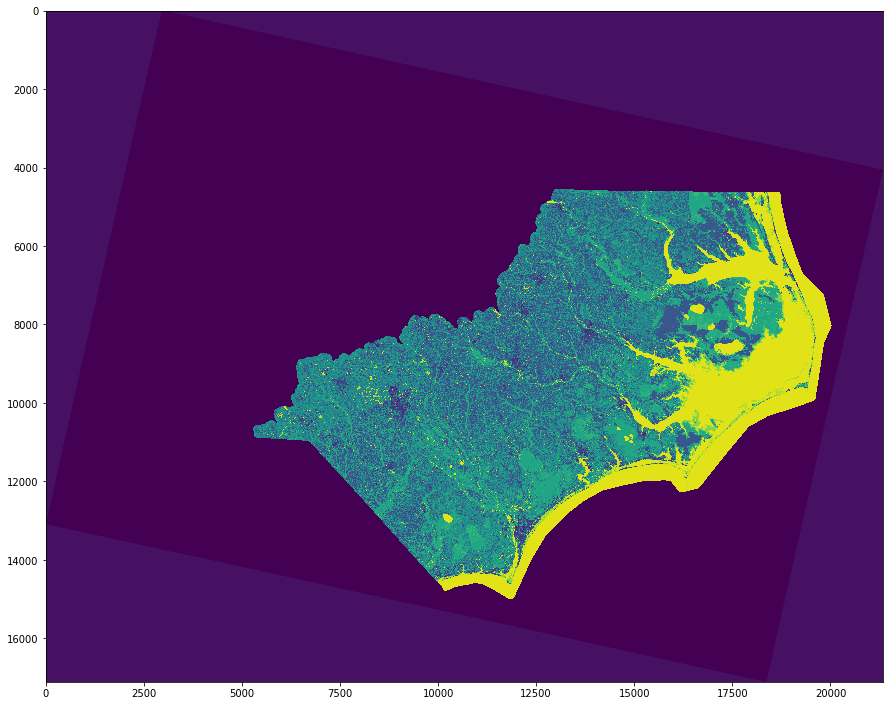

In [8]:
fig, ax = plt.subplots(figsize=[15,15])
ax.imshow(label_image[0,:,:])

Since that isn't very informative let's add a colormap and visualize what's really there

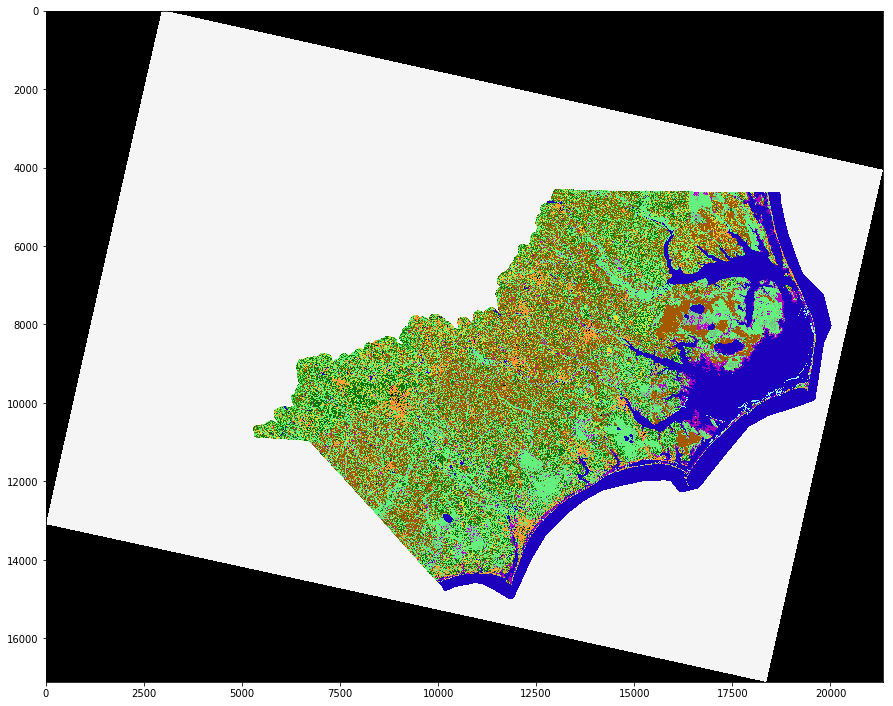

In [9]:
# next setup a colormap for our map
colors = dict((
(0, (245,245,245, 255)), # Background
(1, (0,0,0)), # Unclassified (Cloud, Shadow, etc)
(2, (255,0,0)), # High Intensity Developed
(3, (255, 110, 51)), # Medium Intensity Developed
(4, (255, 162, 51)), # Low Intensity Developed
(5, (255, 162, 51)), # Open Space Developed
(6, (162, 89, 0)), # Cultivated Land
(7, (229, 221, 50)), # Pasture/Hay
(8, (185, 251, 96)), # Grassland
(9, (83, 144, 0)), # Deciduous Forest
(10, (13, 118, 0  )), # Evergreen Forest
(11, (62, 178, 49)), # Mixed Forest
(12, (100, 241, 125)), # Scrub/Shrub
(13, (68, 160, 85)), # Palustrine Forested Wetland
(14, (118, 192, 131)), # Palustrine Scrub/Shrub Wetland
(15, (188, 0, 211)), # Palustrine Emergent Wetland
(16, (188, 0, 211)), # Estuarine Forested Wetland
(17, (0, 0, 0)), # Estuarine Scrub/Shrub Wetland
(18, (172, 0, 191)), # Estuarine Emergent Wetland
(19, (159, 251, 255)), # Unconsolidated Shore 
(20, (172, 177, 68)), # Bare Land
(21, (29, 0, 189)), # Water
(22, (29, 0, 189)), # Palustrine Aquatic Bed
(23, (91, 199, 169)), # Estuarine Aquatic Bed
(24, (159, 251, 255)), # Tundra
(25, (159, 251, 255)), # Snow/Ice
))

n = int(np.max(label_image))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the class map next to the RGB image

fig, axs = plt.subplots(figsize=(15,15))

axs.imshow(label_image[0,:, :], cmap=cmap, interpolation='none')
#axs.imshow(image[0,:, :], cmap=cmap, interpolation='none')

plt.show()

Let's combine this raster into a more limited subset of classes we care about

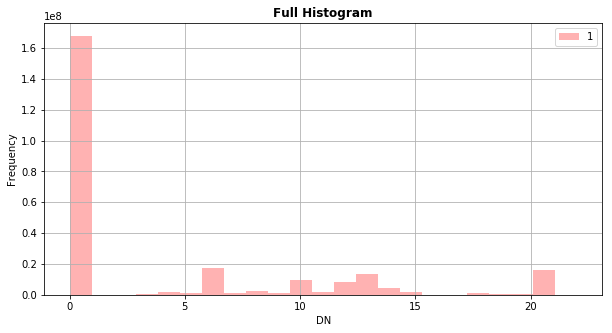

In [57]:
fig, ax = plt.subplots(figsize=(10,5))
show_hist(label_dataset, ax=ax, bins=len(np.unique(label_image)), lw=0.0, stacked=False, 
               histtype='stepfilled', title="Class Distribution")

## Moving to Landsat Inspection

In [12]:
image_dataset = rasterio.open('/deep_data/LC08_CU_028012_20140814_20171017_C01_V01_SR/combined.tif')

# How many bands does this image have?
num_bands = image_dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = image_dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = image_dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = image_dataset.crs
print('Image projection:')
print(proj)

Number of bands in image: 7

Image size is: 5000 rows x 5000 columns

Raster driver: GTiff

Image projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


#### Let's just visualize it to see what's going on

(3, 5000, 5000)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


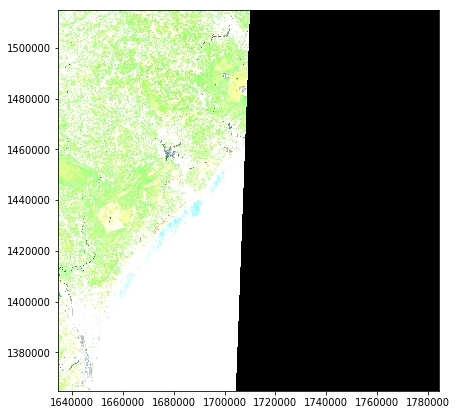

In [51]:
import matplotlib.pyplot as plt
from rasterio.plot import show_hist

full_img = image_dataset.read()
clipped_img = full_img[[3, 2, 1], :, :]
print(clipped_img.shape)
fig, ax = plt.subplots(figsize=(10,7))
show(clipped_img[:, :, :], ax=ax, transform=image_dataset.transform) # add the transform arg to get it in lat long coords

#### Not very informative...

Let's try to normalize it with the built in rasterio adjust_band function

Text(0.5, 1.0, 'RGB in matplotlib imshow')

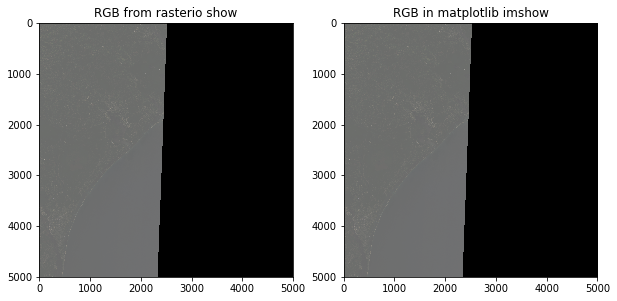

In [52]:
from rasterio.plot import adjust_band, show_hist

img_norm = adjust_band(clipped_img) # normalize bands to range between 1.0 to 0.0
img_reshaped = reshape_as_image(img_norm) # reshape to [rows, cols, bands]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# the rasterio show function takes in [bands, rows, cols] so we don't need to reshape
show(img_norm, ax=axs[0])
axs[0].set_title("RGB from rasterio show")

# plot with normal matplotlib functions
axs[1].imshow(img_reshaped)
axs[1].set_title("RGB in matplotlib imshow")

Still not very useful, let's check out the historgram and normalize it ourselves

In [40]:
print(np.amax(full_img))
print(np.amin(full_img))

14853
-9999


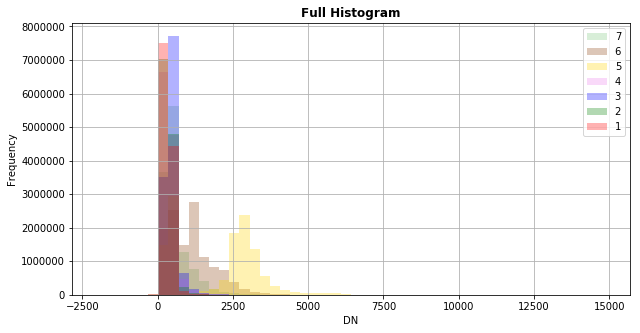

In [44]:
fig, ax = plt.subplots(figsize=(10,5))
show_hist(image_dataset, ax=ax, bins=50, lw=0.0, stacked=False, alpha=0.3, 
               histtype='stepfilled', title="Full Histogram")

In [49]:
from rasterio.plot import reshape_as_raster, reshape_as_image

# Extract reference to SWIR1, NIR, and Red bands
index = np.array([3, 2, 1])
colors = full_img[index, :, :].astype(np.float64)

max_val = 4000
min_val = 0

# Enforce maximum and minimum values
colors[colors[:, :, :] > max_val] = max_val
colors[colors[:, :, :] < min_val] = min_val

for b in range(colors.shape[0]):
    colors[b, :, :] = colors[b, :, :] * 1 / (max_val - min_val)

# rasters are in the format [bands, rows, cols] whereas images are typically [rows, cols, bands]
# and so our array needs to be reshaped
print(colors.shape)
colors_reshaped = reshape_as_image(colors)
print(colors_reshaped.shape)

(3, 5000, 5000)
(5000, 5000, 3)


Text(0.5, 1.0, 'RGB in matplotlib imshow')

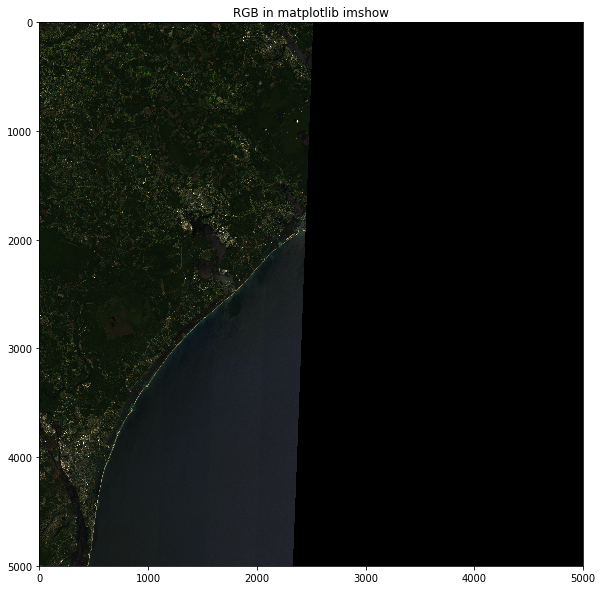

In [50]:
fig, ax = plt.subplots(figsize=(10, 10))

# plot with normal matplotlib functions
ax.imshow(colors_reshaped)
ax.set_title("RGB in matplotlib imshow")

### okay that's what it should really look like!